In [1]:
import numpy as np
from scio import scio
from matplotlib import pyplot as plt
import sys
sys.path.insert(0, "/home/mohan/Projects/")
from albatros_analysis.src.utils import baseband_utils as butils
from astropy.time import Time
from astropy.coordinates import EarthLocation
import datetime
import os
from scipy.ndimage import median_filter

In [2]:
str2time = lambda tstr: int(datetime.datetime.strptime(tstr, "%Y%m%d").timestamp())
def unix2jd(ctime):
    return ctime / 86400 + 2440587.5

In [4]:
dtsts = ["20241201"]  # start times nautical twilight at MARS
dtens = ["20241231"]  # end times
paths = [
    "/home/mohan/csa_dec2024",
]
# dtsts = ["20231201"]  # start times nautical twilight at MARS
# dtens = ["20231231"]  # end times
# paths = [
#     "/home/mohan/uapishka_dec23",
# ]
fnames = []
tag="pol00"
for datebegin, dateend, path in zip(dtsts, dtens, paths):
    print("starting for files between", datebegin, dateend)
    fnames.extend(
        butils.time2fnames(str2time(datebegin), str2time(dateend), path, "d")
        )
valid_fnames = fnames.copy()
# for fname in fnames:
#     hh = datetime.datetime.fromtimestamp(
#         butils.get_tstamp_from_filename(fname)
#     ).hour
#     month = datetime.datetime.fromtimestamp(
#         butils.get_tstamp_from_filename(fname)
#     ).month
# #     print(fname,month,hh)
#     # Remove daytime data to not have solar RFI
#     if month > 3 and month < 10:  # rough summer daytime
#         if hh < 22 and hh > 4:
#             valid_fnames.remove(fname)
#     else:
#         if hh < 18 and hh > 4:  # rough winter daytime
#             valid_fnames.remove(fname)
#             print("removed", fname, month, hh)
print(f"found {len(valid_fnames)} valid files")
new_fnames = [os.path.join(ff, tag + ".scio.bz2") for ff in valid_fnames]

starting for files between 20241201 20241231
found 713 valid files


In [5]:
files=scio.read_files(new_fnames)

In [6]:
flags=[False]*len(files)

In [7]:
numrows=0
for ii,file in enumerate(files):
    if file is None:
        flags[ii]=True
        print(f"file {ii} is None")
        continue
    if file.shape[0] < 10 or np.min(file) == 0:
        flags[ii]=True
        print(f"file {ii} has too few rows or has 0 power somewhere")
        continue
    numrows += file.shape[0]  # determine total number of rows

In [8]:
ctime_arr = np.zeros(numrows, dtype="float64")
large_arr = np.zeros((numrows, 2048), dtype="float64")

In [9]:
curidx=0
for fnum, file in enumerate(files):
    if flags[fnum]:
        continue
    ss = file.shape[0]
    tt = butils.get_tstamp_from_filename(valid_fnames[fnum])
    large_arr[curidx : curidx + ss, :] = file
    ctime_arr[curidx : curidx + ss] = (
        tt + np.arange(ss) * 6.44
    )  # acclen 393216 = 6.44s. Each row of direct data is 6.44s long.
    curidx += ss

In [20]:
ctime_arr

array([1.73302954e+09, 1.73302954e+09, 1.73302955e+09, ...,
       1.73562141e+09, 1.73562142e+09, 1.73562142e+09])

In [10]:
nbins=48
dH = 24/nbins
jds = unix2jd(ctime_arr) 
main_ant = EarthLocation.from_geodetic(
    lat=79+23.308/60, lon=-(90+1.156/60), height=22
) #CSA
# main_ant = EarthLocation.from_geodetic(
#     lat=51.4641932, lon=-68.2348603, height=336.499
# ) #Uap
atime = Time(jds, format="jd", scale="utc", location=main_ant)
lstimes = atime.sidereal_time("mean").value
lstbins = np.round(lstimes / dH).astype(int)

In [11]:
np.unique(lstbins,return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]),
 array([4037, 8061, 8066, 8068, 8065, 8286, 8351, 8339, 8598, 8624, 8625,
        8612, 8344, 8341, 8346, 8347, 8344, 8343, 8348, 8342, 8338, 8345,
        8346, 8343, 8347, 8341, 8345, 8343, 8277, 8199, 8192, 8260, 8270,
        8279, 8342, 8343, 8339, 8129, 8065, 8068, 8068, 8067, 8061, 8065,
        8064, 8067, 8066, 8073, 4026]))

In [12]:
idx=np.where(lstbins==10)[0]
print(len(idx))

8625


In [13]:
dH

0.5

In [14]:
dat=large_arr[idx,:].copy()

In [15]:
dat.shape

(8625, 2048)

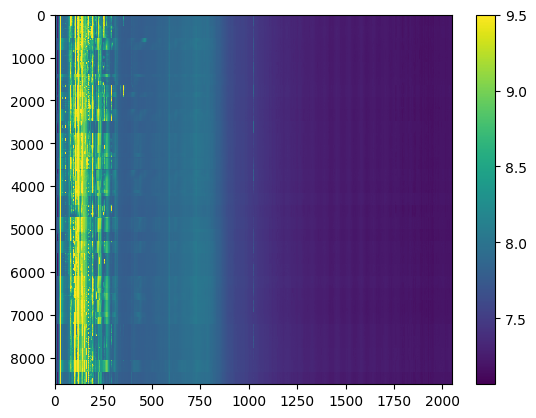

In [16]:
plt.imshow(np.log10(dat),aspect='auto',vmax=9.5,interpolation='none')
plt.colorbar()

In [92]:
with np.load("/home/mohan/Downloads/uapishka_dec2022_bot5.npz") as f:
    bot5_uapishka=f['data']

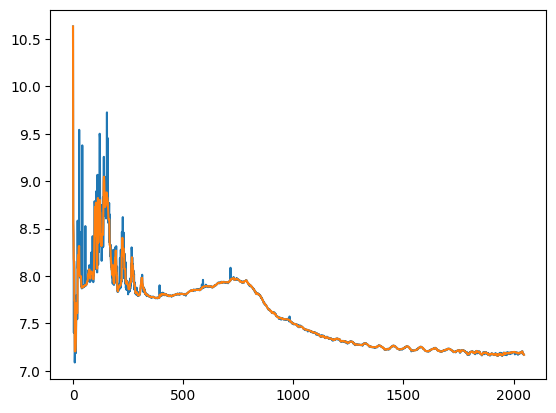

In [17]:
bot5=np.percentile(dat,5,axis=0)
bot5_mf = median_filter(bot5, size=5,mode='nearest',axes=1)
plt.plot(np.log10(bot5))
plt.plot(np.log10(bot5_mf))

In [27]:
bot5_uapishka=np.percentile(dat,5,axis=0)
bot5_uapishka_mf = median_filter(bot5_uapishka, size=5,mode='nearest',axes=1)
plt.plot(np.log10(bot5_uapishka))
plt.plot(np.log10(bot5_uapishka_mf))

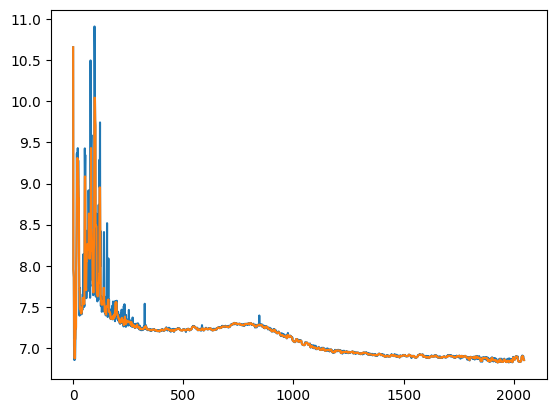

In [28]:
# plt.plot(np.log10(bot5))



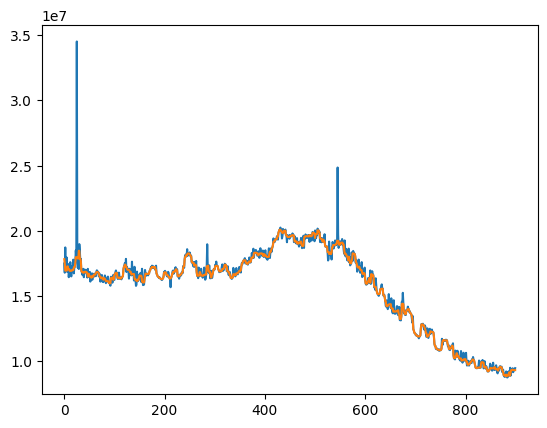

In [34]:
plt.plot(bot5_uapishka[300:1200])
plt.plot(bot5_uapishka_mf[300:1200])

In [18]:
with np.load("/home/mohan/Projects/fee-analysis/fee_predictions.npz") as f:
    freqs=f['freqs']
    lwa_power=f['lwa_power']
    alb_power=f['alb_power']
    noise_alb = f['noise_alb']
    noise_lwa = f['noise_lwa']
ff=np.linspace(0,125,2048)
alb_power_interp=np.interp(ff,freqs,alb_power)
lwa_power_interp=np.interp(ff,freqs,lwa_power)
alb_noise_interp=np.interp(ff,freqs,noise_alb)
lwa_noise_interp=np.interp(ff,freqs,noise_lwa)

In [19]:
x=alb_power_interp[300:1500].copy() #+ alb_noise_interp[300:1000].copy()
y=bot5_mf[300:1500].copy()
A=np.zeros((len(y),2),dtype='float64')
A[:,0]=x
A[:,1]=1
norm=np.linalg.inv(A.T@A)
m,c=np.dot(norm,A.T@y)

In [20]:
m,c

(1.3273307195976614e+25, 17777934.7761683)

In [18]:
x=alb_power_interp[300:1500].copy() #+ alb_noise_interp[300:1200].copy()
y=bot5_uapishka[300:1500].copy()
A=np.zeros((len(y),2),dtype='float64')
A[:,0]=x
A[:,1]=1
norm=np.linalg.inv(A.T@A)
m,c=np.dot(norm,A.T@y)

In [19]:
m,c

(2.2400669187072697e+24, 8854549.401135212)

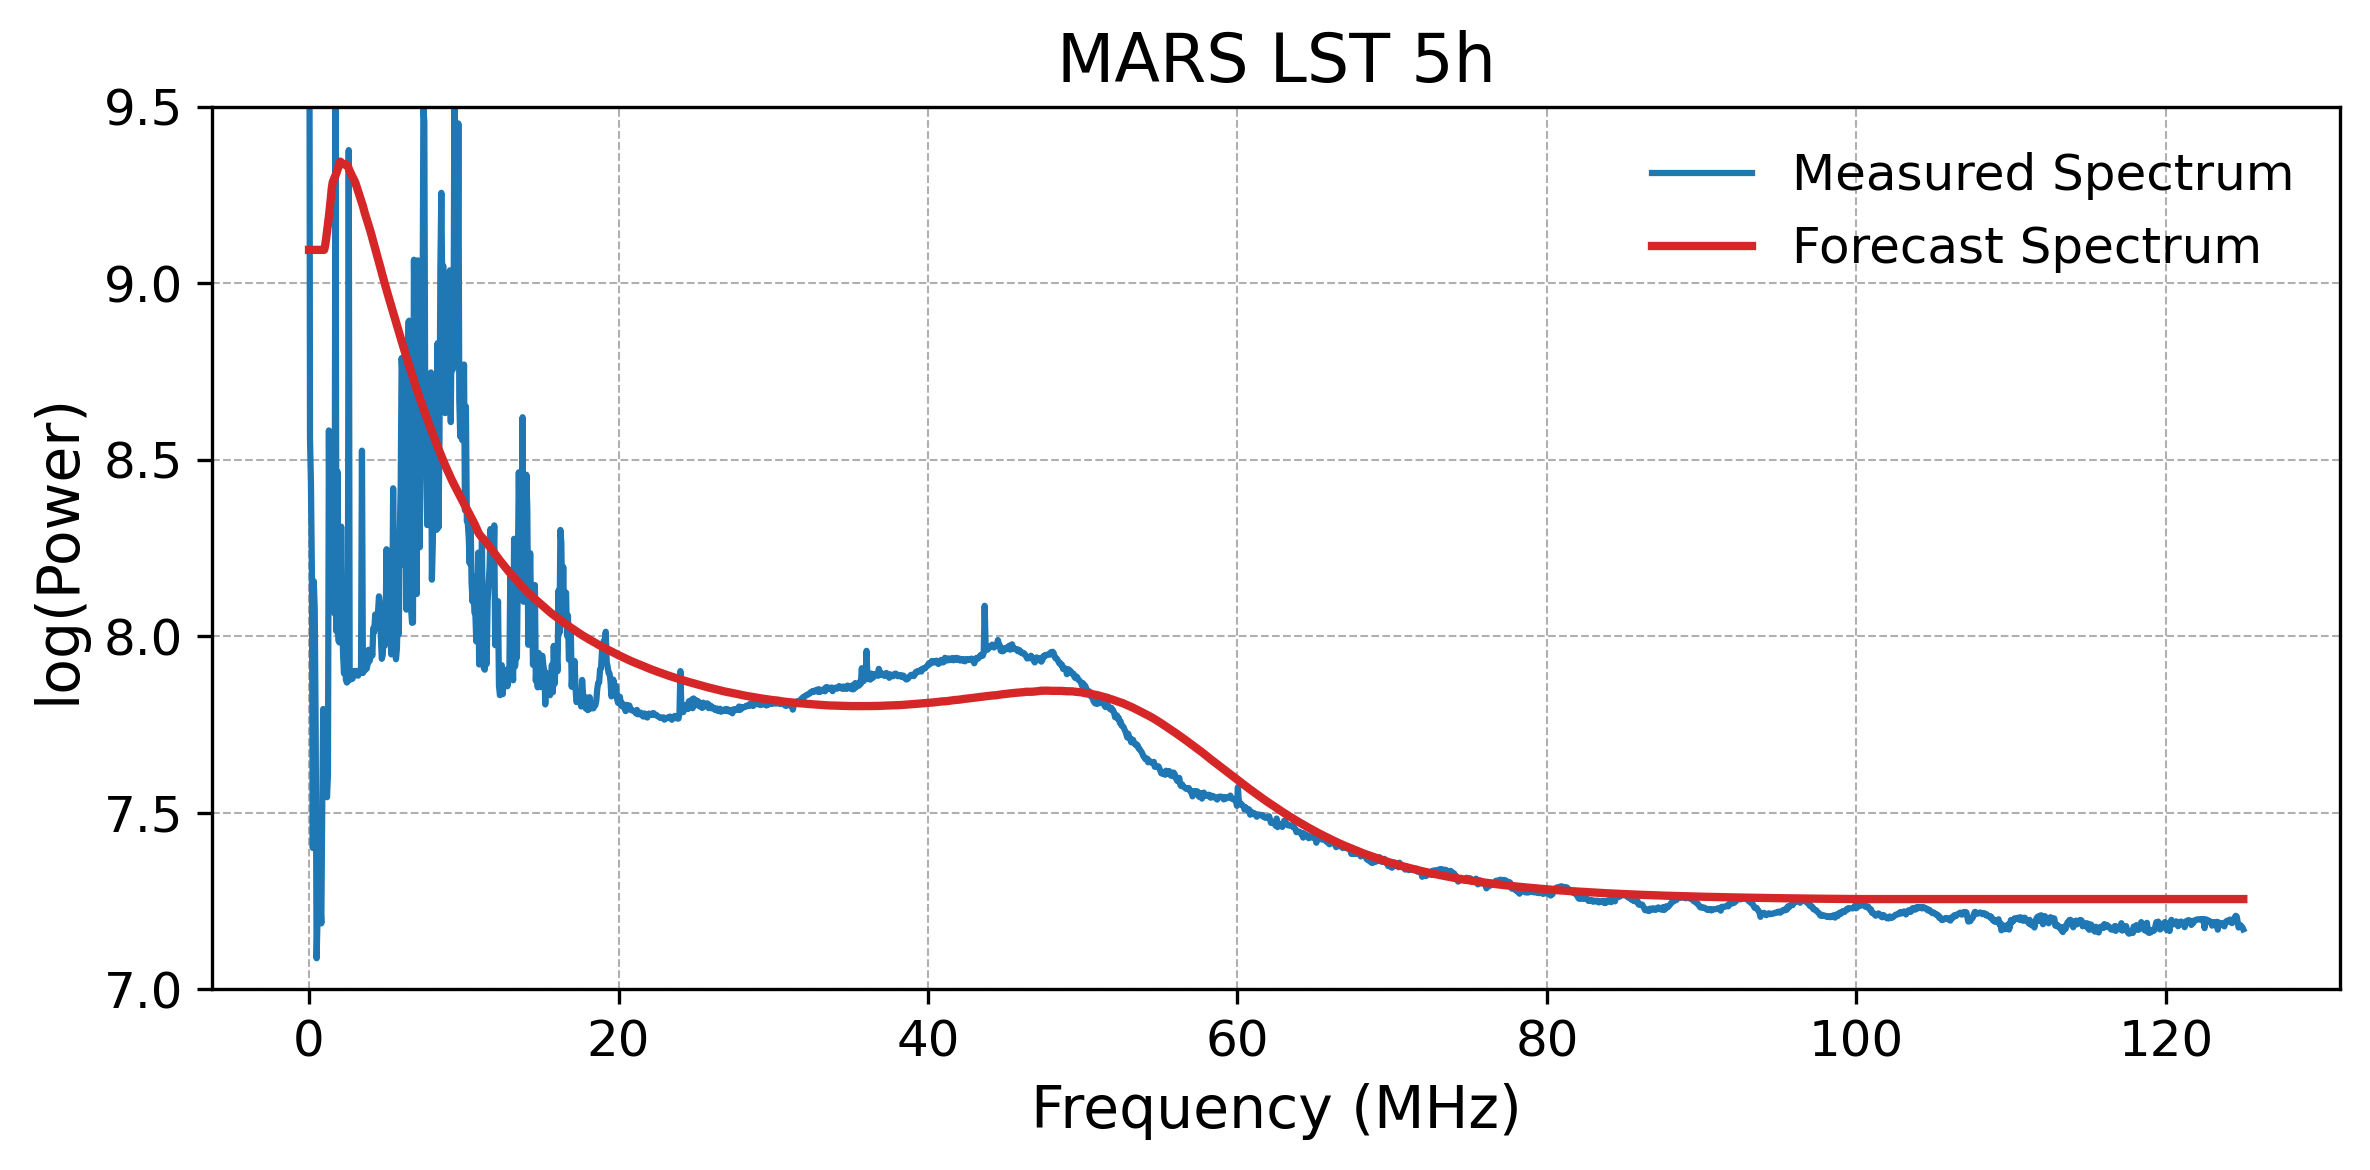

In [25]:
plt.figure(figsize=(8, 4), dpi=300)

plt.plot(ff, np.log10(bot5[:]), label='Measured Spectrum', color='#1f77b4', linewidth=1.5)
plt.plot(ff, np.log10(m * alb_power_interp[:] + c), label='Forecast Spectrum', color='#d62728', linewidth=2)

plt.xlabel("Frequency (MHz)", fontsize=14)
plt.ylabel(r"log(Power)", fontsize=14)
plt.title("MARS LST 5h", fontsize=16)

plt.ylim(7, 9.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(fontsize=12, loc='upper right', frameon=False)

plt.tight_layout()
plt.show()

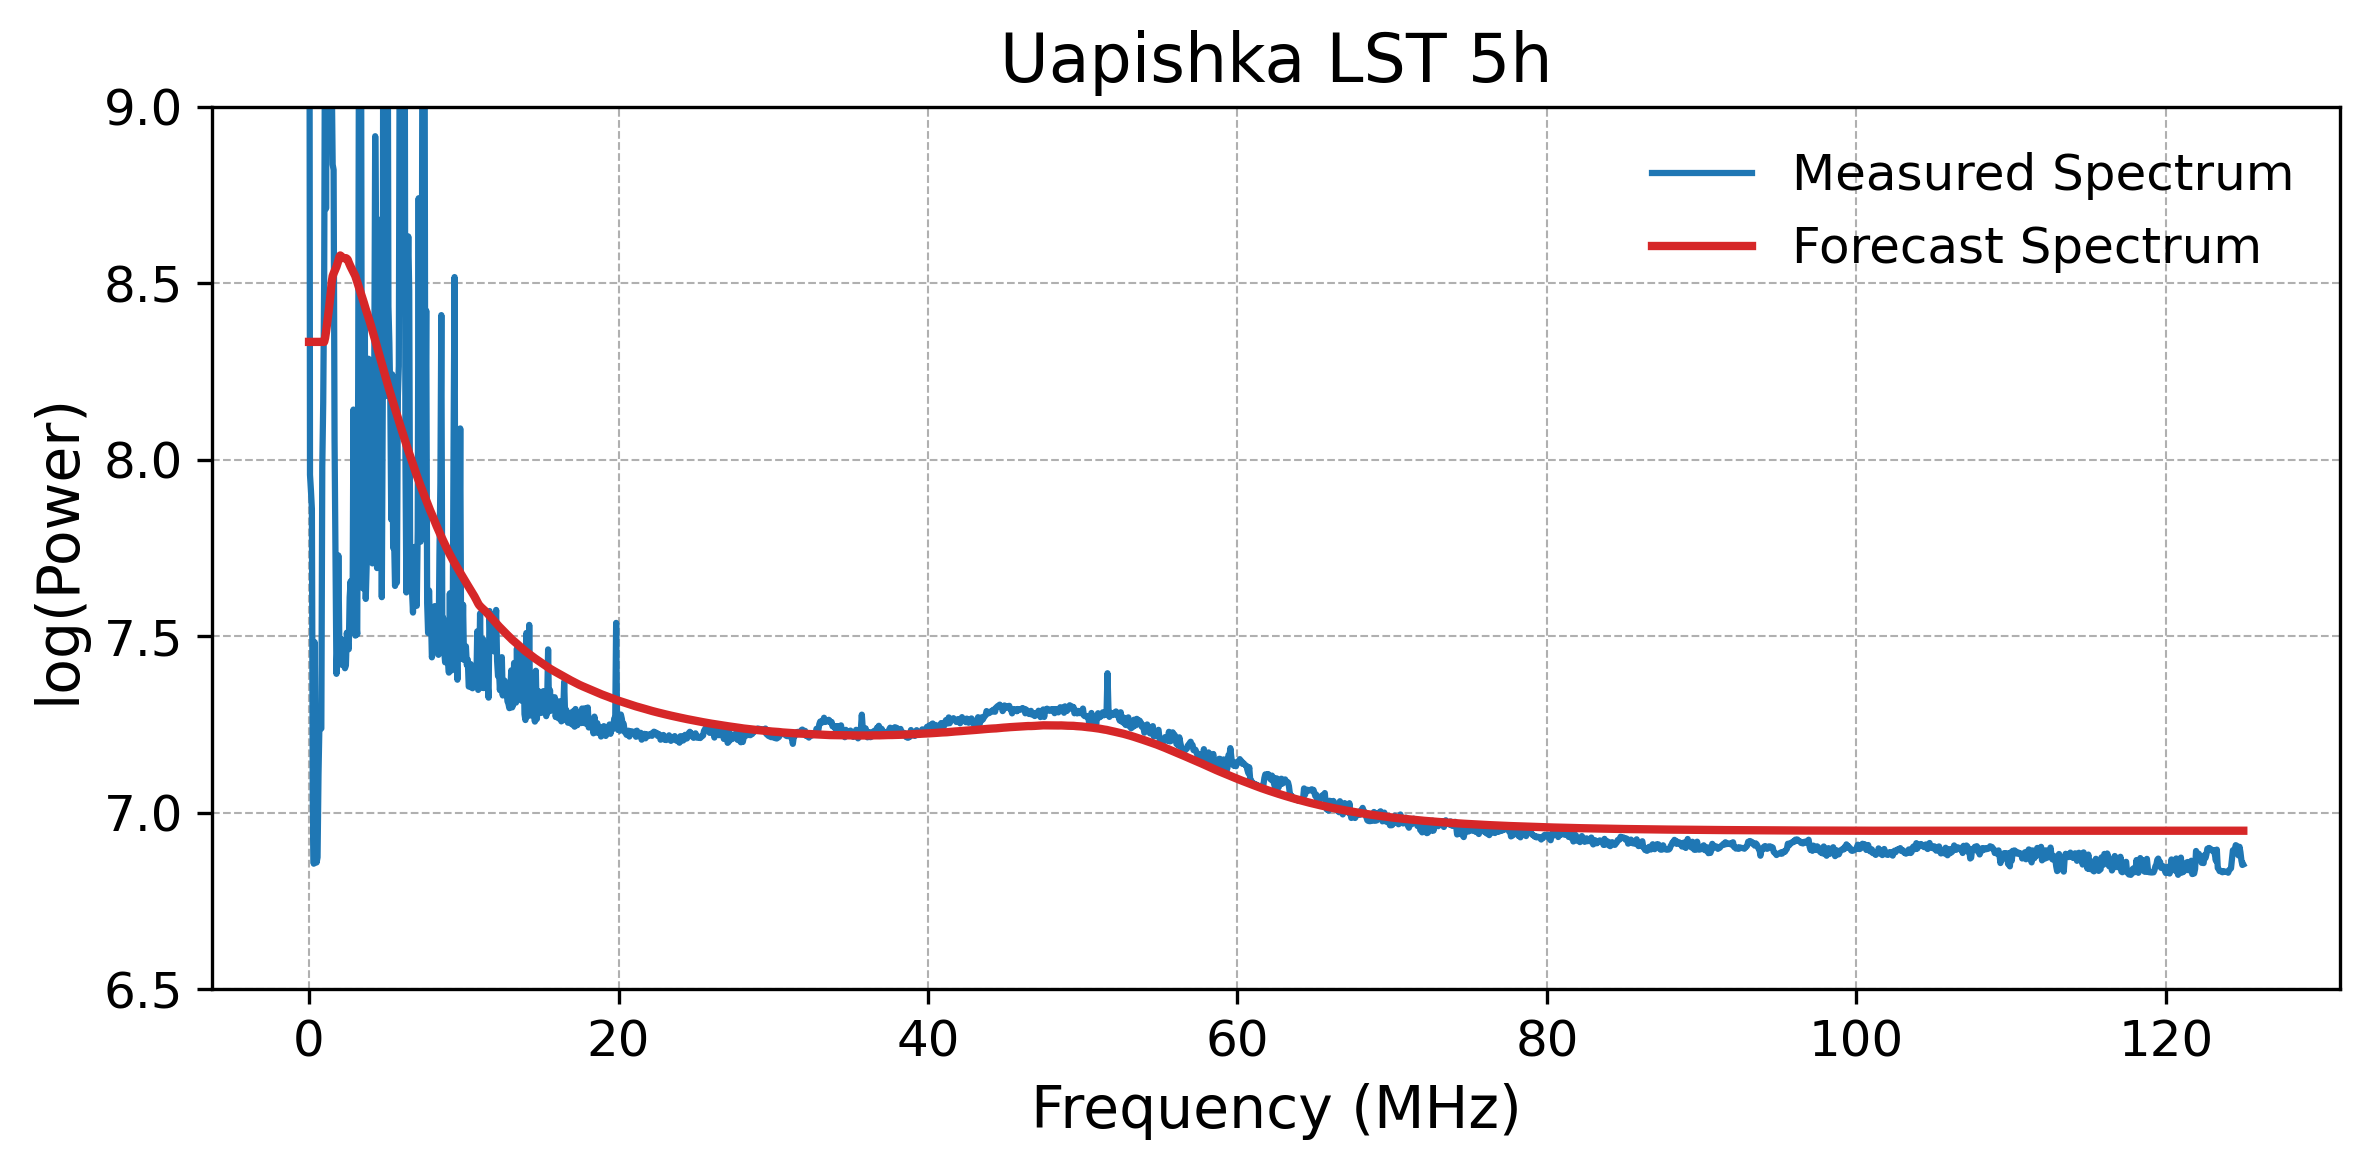

In [20]:
plt.figure(figsize=(8, 4), dpi=300)

plt.plot(ff, np.log10(bot5_uapishka[:]), label='Measured Spectrum', color='#1f77b4', linewidth=1.5)
plt.plot(ff, np.log10(m * alb_power_interp[:] + c), label='Forecast Spectrum', color='#d62728', linewidth=2)

plt.xlabel("Frequency (MHz)", fontsize=14)
plt.ylabel(r"log(Power)", fontsize=14)
plt.title("Uapishka LST 5h", fontsize=16)

plt.ylim(6.5, 9)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(fontsize=12, loc='upper right', frameon=False)

plt.tight_layout()
plt.show()

(6.5, 9.0)

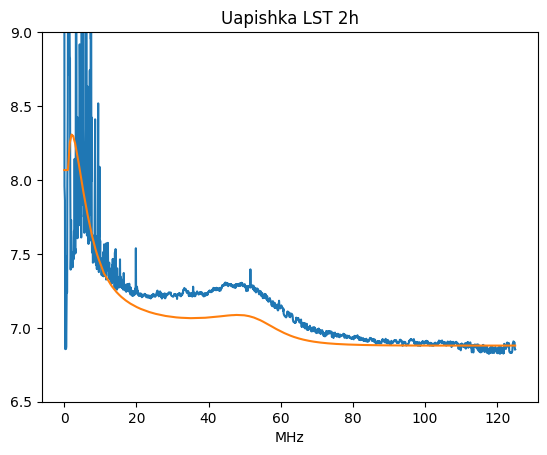

In [57]:
plt.plot(ff,np.log10(bot5_uapishka[:]))
plt.plot(ff,np.log10(m*alb_power_interp[:]+c))
plt.xlabel("MHz")
plt.title("Uapishka LST 2h")
plt.ylim(6.5,9)

Text(0.5, 0, 'MHz')

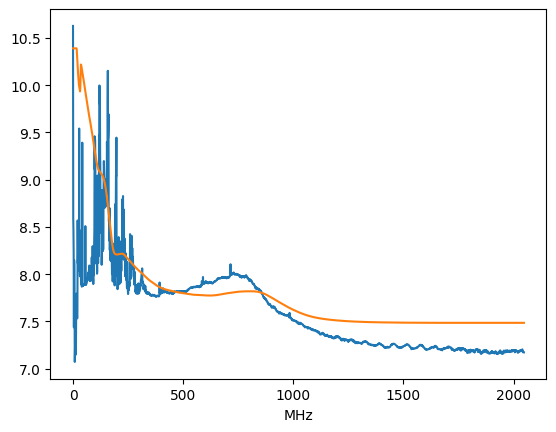

In [90]:
plt.plot(np.log10(bot5[:]))
plt.plot(np.log10(m*alb_power_interp[:]+c))
plt.xlabel("MHz")

Text(0.5, 0, 'MHz')

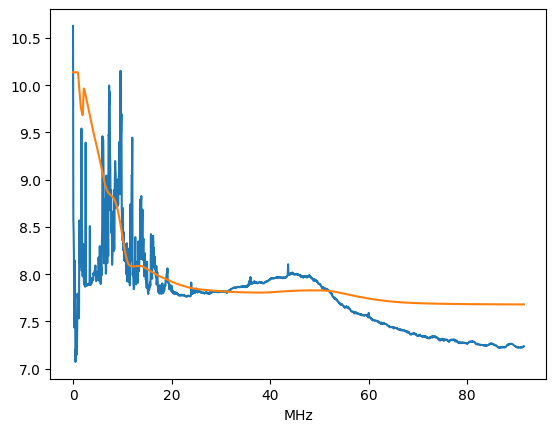

In [77]:
plt.plot(ff[:1500],np.log10(bot5[:1500]))
plt.plot(ff[:1500],np.log10(m*alb_power_interp[:1500]+c))
plt.xlabel("MHz")

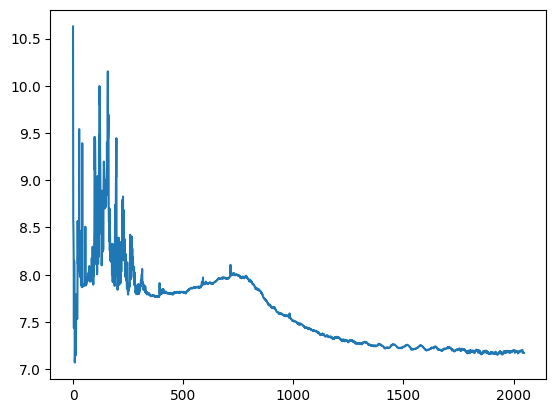

In [88]:
plt.plot(np.log10(bot5))

In [67]:
300*0.061,1500*0.061

(18.3, 91.5)